In [1]:
import os
import sys
pp_path = os.path.join("..", "pySMOKEPostProcessor")
sys.path.append(pp_path)
from RateOfProductionAnalysis import RateOfProductionAnalysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
%%time
pathkin = 'ROPA-02/Kinetics'
outxml = 'ROPA-02/Results/Output'

ropa = RateOfProductionAnalysis(pathkin, outxml)
C, P = ropa.ComputeRopa(specie = 'H2', ropa_type = 'global')

CPU times: user 3.49 s, sys: 83.5 ms, total: 3.58 s
Wall time: 3.58 s


In [3]:
nonzero_P = np.nonzero(P)[0] 
nonzero_C = np.nonzero(C)[0]
ROPA_results = {'id_P': [], 'P_reactions': [], 'ROPA_Coeff_P': [],'id_C': [],
                'C_reactions': [], 'ROPA_Coeff_C': []}

if len(nonzero_P) != 0:
    for i in nonzero_P:
        ROPA_results['id_P'].append(i)
        ROPA_results['P_reactions'].append(ropa.reactionsNames[i])
        ROPA_results['ROPA_Coeff_P'].append(P[i])

if len(nonzero_C) != 0:
    for j in nonzero_C:

        ROPA_results['id_C'].append(j)
        ROPA_results['C_reactions'].append(ropa.reactionsNames[j])
        ROPA_results['ROPA_Coeff_C'].append(-C[j])

ROPA_results_plot = {'Reactions': [], 'Coefficients': []}
ROPA_results_plot['Reactions'].append(ROPA_results['P_reactions'] + ROPA_results['C_reactions'])
ROPA_results_plot['Coefficients'].append(ROPA_results['ROPA_Coeff_P'] + ROPA_results['ROPA_Coeff_C'])

ROPA_results_plot['Reactions'] = ROPA_results_plot['Reactions'][0]
ROPA_results_plot['Coefficients'] = ROPA_results_plot['Coefficients'][0]

# print(ROPA_results_plot)


df = pd.DataFrame.from_dict(ROPA_results_plot)
df['Coefficients_abs'] = abs(df['Coefficients'])
df = df.sort_values(by=['Coefficients_abs'])

df_last_15 = df.iloc[-15:]
df_last_15.reset_index(inplace = True)

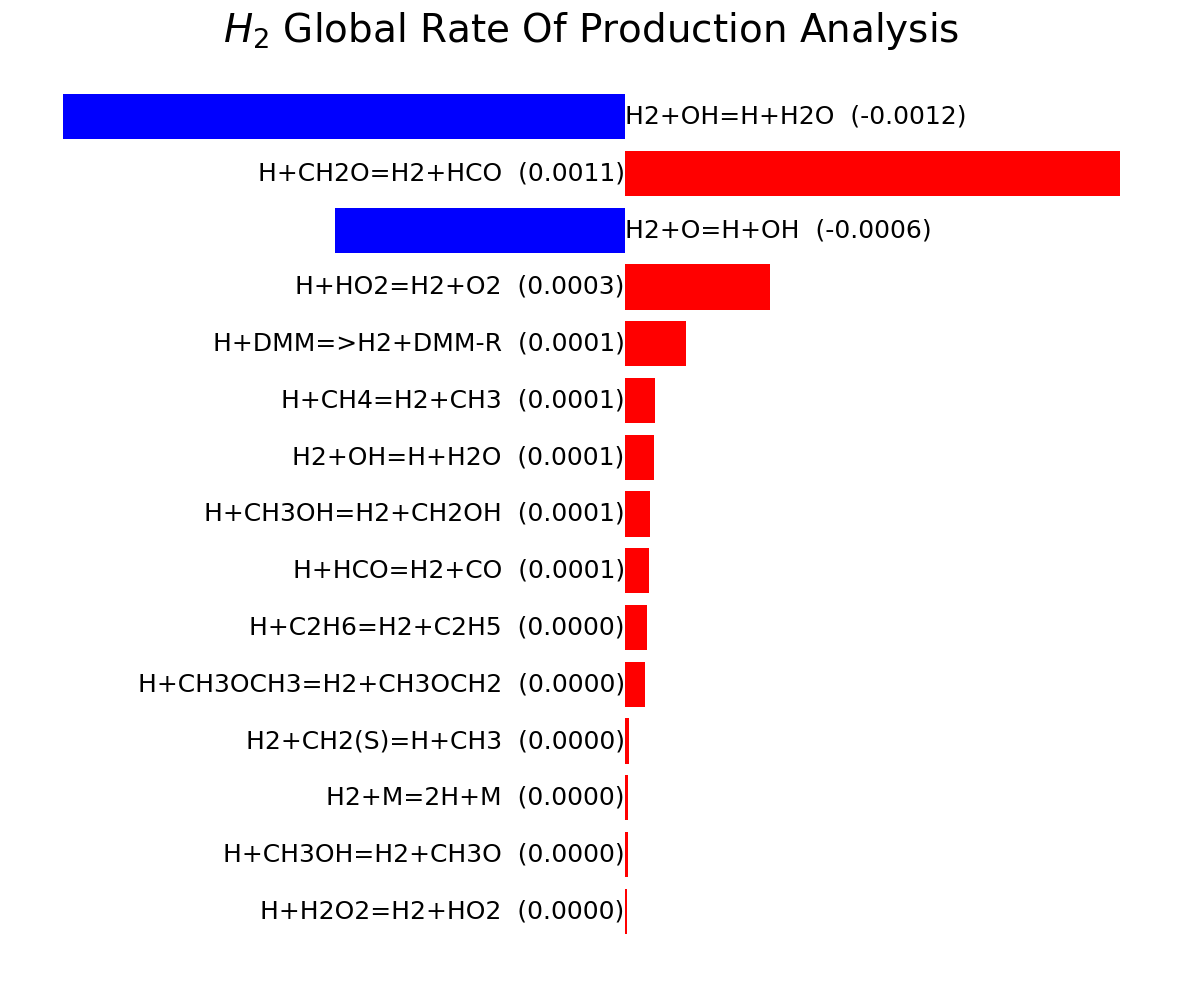

In [4]:
df = df_last_15
fig = plt.figure(figsize=(15, 12))
ax = plt.subplot()
ax.set_title("$H_{2}$ Global Rate Of Production Analysis", fontsize=28)
bar = ax.barh(df.index, 
              df['Coefficients'], 
              color = (df['Coefficients'] >= 0.).map({True:'red', False:'blue'}))

for idx, i in enumerate(bar):
    x = i.get_width()
    y = i.get_y()+0.5*i.get_height()
    if(x<0):
        ax.text(0, y, 
            df['Reactions'][idx] + "  (" + str('{:6.4f}'.format(df["Coefficients"][idx])) + ")", 
            va='center', fontsize=18)
    else:
        ax.text(0,
                y, 
                df['Reactions'][idx] + "  (" + str('{:6.4f}'.format(df["Coefficients"][idx])) + ")", 
                va='center',
                ha='right',
                fontsize=18) 

ax.set_yticks(np.arange(0, 10, 1))
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.axis("off")
plt.show()